# Using LSTM RNN to predict stock price 

In [1]:
import numpy as np
import pandas as pd

In [2]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,GlobalAveragePooling1D,
from keras.models import Model, Sequential
from keras.layers import merge
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from keras import backend as K

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is enabled)


# import stock data using pandas data reader

In [3]:
import pandas_datareader.data as web
from datetime import datetime

In [4]:
# look up ticker BABA from google finance
baba = web.DataReader('BABA', 'google', start=datetime(2016, 1, 1), end=datetime(2016, 6, 1))
training_set=pd.DataFrame(baba['Close'].values)
training_set.shape
training_set.head()

,0
0,76.69
1,78.63
2,77.33
3,72.72
4,70.80


In [5]:
baba = web.DataReader('BABA', 'google', datetime(2017, 1, 1), datetime(2017, 5, 1))
validate_set=pd.DataFrame(baba['Close'].values)
validate_set.shape

(82, 1)

In [7]:
#Normalize the raw data
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
training_scaled=sc.fit_transform(training_set)
validate_scaled=sc.fit_transform(validate_set)

In [56]:
date_range=3

In [57]:
#create function to loop through data, where each training data point usese the prior X day data for learning.

def data_process(scaled_data):
    X=[]
    Y=[]
    num_data=len(scaled_data)
    for i in range(date_range, num_data):
        X.append(scaled_data[i-date_range:i, 0])
        Y.append(scaled_data[i, 0])
    
    return  np.array(X), np.array(Y)

In [58]:
X_train, target=data_process(training_scaled)
X_train_input=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1) )
X_train_input.shape

(101, 3, 1)

In [59]:
X_val, y_val=data_process(validate_scaled)
X_val_input=np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1) )
X_val_input.shape

(79, 3, 1)

# Build the model

In [63]:
reg_model=Sequential()
reg_model.add(LSTM(128, input_shape=(3,1), return_sequences=True)) # each data point consists of 3 days of closing pice data.
reg_model.add(LSTM(64, return_sequences=True))
reg_model.add(LSTM(16))
reg_model.add(Dense(1, activation='linear'))

In [64]:
reg_model.compile(optimizer='adam', loss='mean_squared_error')

In [65]:
reg_model.fit(X_train_input, target, validation_data=(X_val_input, y_val), batch_size=32, nb_epoch=100, verbose=1)

Train on 101 samples, validate on 79 samples
Epoch 1/100
101/101 [==============================] - 0s - loss: 0.4130 - val_loss: 0.2702
Epoch 2/100
101/101 [==============================] - 0s - loss: 0.2993 - val_loss: 0.1770
Epoch 3/100
101/101 [==============================] - 0s - loss: 0.1876 - val_loss: 0.0842
Epoch 4/100
101/101 [==============================] - 0s - loss: 0.0828 - val_loss: 0.0158
Epoch 5/100
101/101 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0154
Epoch 6/100
101/101 [==============================] - 0s - loss: 0.0346 - val_loss: 0.0353
Epoch 7/100
101/101 [==============================] - 0s - loss: 0.0412 - val_loss: 0.0152
Epoch 8/100
101/101 [==============================] - 0s - loss: 0.0196 - val_loss: 0.0062
Epoch 9/100
101/101 [==============================] - 0s - loss: 0.0155 - val_loss: 0.0100
Epoch 10/100
101/101 [==============================] - 0s - loss: 0.0209 - val_loss: 0.0125
Epoch 11/100
101/101 [============

# plot validation data vs. predicted data

In [66]:
prediction_scaled=reg_model.predict(X_val_input)
prediction=sc.inverse_transform(prediction_scaled)
y_val_unscaled=sc.inverse_transform(y_val)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:377: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

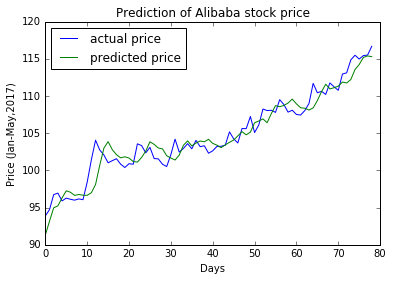

In [68]:
plt.plot(y_val_unscaled, color='blue', label='actual stock price')
plt.plot(prediction, color='green', label='predicted stock price')

plt.title('Prediction of Alibaba stock price')
plt.ylabel('Price (Jan-May,2017)')
plt.xlabel('Days')
plt.legend(['actual price', 'predicted price'], loc='upper left')